In [1]:
import os
import requests
import torch

from src.tokenizer import CharTokenizer

__file__='shakespeare_data/'

# download the tiny shakespeare dataset
input_file_path = os.path.join(os.path.dirname(__file__), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)


#create the tokenizer
tokenizer=CharTokenizer(input_file_path)
print('tokenizer vocab size:', tokenizer.vocab_size)


length of dataset in characters: 1,115,394
tokenizer vocab size: 65


In [2]:
# load the data
with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")


# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = tokenizer(train_data)
val_ids = tokenizer(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
torch.save(train_ids, os.path.join(os.path.dirname(__file__), 'train.bin'))
torch.save(val_ids,   os.path.join(os.path.dirname(__file__), 'val.bin'))

length of dataset in characters: 1,115,394
train has 1,003,854 tokens
val has 111,540 tokens


In [3]:
import torch
from torch import nn
from IPython.display import clear_output

from src.encoder import Encoder, GPT2Encoder
from src.decoder import Decoder, GPT2Decoder
from src.graph_initialization import random_unidirectional_graph_maker, linear_unidirectional_graph_maker
from src.graphAN import GraphAttentionNetwork, BlockGenerator
from src.data_loader import validation
from src.tokenizer import Tokenizer
from src.GPT2 import GPT2_Block, GPT2
from matplotlib import pyplot as plt
from src.utils import moving_average, grad_norm
from torch.nn.utils import clip_grad_norm_
import pickle
import numpy as np
from termcolor import colored



In [4]:
device = 'cpu'
#device = 'mps'  if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device

dK = 16
dV = 16
heads = 6
d_Embedding = dK*heads
intermediate_size=intermediate_size=2*d_Embedding


encoder = Encoder(d_Embedding, tokenizer, dropout=0, device=device)
decoder = Decoder(encoder)
block_generator = BlockGenerator(GPT2_Block, d_Embedding, dK, dV, heads, intermediate_size,
                                 dropout=0.1, split_size=2**10, device=device, rotary_encoding=True)

model = GraphAttentionNetwork(tokenizer, encoder, block_generator, decoder)
model.losses = []
model.validation_losses = []

#model.load('shakespeare_data/pretrained_CE=1.3.pth')


graph_maker = linear_unidirectional_graph_maker(50, device=device)

In [5]:
from src.decoder import Loss

loss_function = Loss(decoder)
ce_loss = nn.CrossEntropyLoss()

lr = 8e-4
gamma = 0.99

grad_norms = []

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

In [6]:
from numpy.random import randint
def sample_shakespeare(data, lenght, starting_index=None):
    lenght=int(lenght)
    
    if starting_index is None:
        starting_index = randint(0, len(data)-lenght)

    if starting_index+lenght>=len(data):
        return data[starting_index:]    
    
    return data[starting_index:starting_index+lenght]


In [7]:
inp=sample_shakespeare(train_ids, 20)

nodes = inp[:-1]
target = inp[1:]
nodes,target

(tensor([59, 45, 46, 58, 57,  1, 54, 43, 53, 54, 50, 43,  1, 58, 46, 47, 57,  1,
         50]),
 tensor([45, 46, 58, 57,  1, 54, 43, 53, 54, 50, 43,  1, 58, 46, 47, 57,  1, 50,
         47]))

Validation loss: 14.71


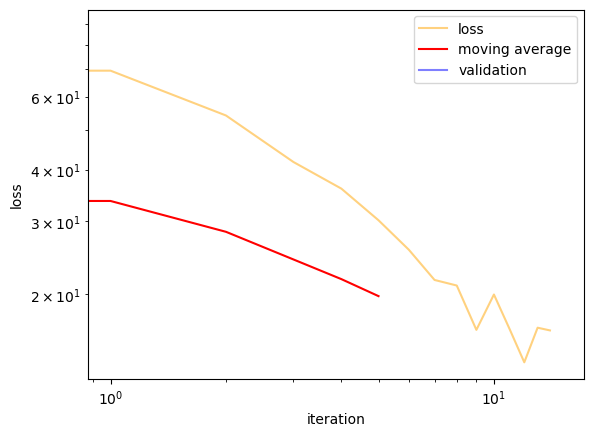

N:15000/1003854, tokens:199, loss:17.19
grad_norm:58.09
N:16000/1003854, tokens:199, loss:13.87
grad_norm:42.69
N:17000/1003854, tokens:199, loss:15.13


KeyboardInterrupt: 

In [8]:
#@title {vertical-output: true}
#@markdown # Training
#@markdown the loss function is cross entropy ❌🎲

n_epochs = int(200)
model.train()
context_size=2e2
model.train()
for i in range(n_epochs):

    
    inp=sample_shakespeare(train_ids, context_size)

    nodes = inp[:-1]
    target = inp[1:]
    edge_index = graph_maker(nodes.shape[0])
    prediction = model(nodes, edge_index)
    loss = loss_function(prediction, target)

    print(f'N:{int(i*1e3)}/{len(train_ids)}, tokens:{nodes.shape[0]}, loss:{loss.item():.2f}')
    model.losses.append(loss.item())
    loss.backward()

    gn = grad_norm(model)
    print(f'grad_norm:{gn:.2f}')
    grad_norms.append(gn)
    clip_grad_norm_(model.parameters(), 4*loss.item())

    optimizer.step()
    optimizer.zero_grad()  # reinitialize the gradient to zero

    if i%15==14:
        clear_output()
        scheduler.step()

        m_av = moving_average(model.losses, 10)
        model.best_loss = min(m_av)

        if model.best_loss<2:
            context_size=1e3

        if model.best_loss<1.5:
            context_size=5e3

        inp=sample_shakespeare(val_ids, 1e3)
        nodes=inp[:-1]
        target=inp[1:]
        edge_index = graph_maker(nodes.shape[0])
        prediction = model(nodes, edge_index)
        validation_loss = loss_function(prediction, target)

        model.validation_losses.append(validation_loss.item())

        print(f'Validation loss: {validation_loss:.2f}')

        plt.plot(model.losses, label='loss', color='orange', alpha=0.5)
        plt.plot(m_av, label='moving average', color='red')
        plt.plot(np.arange(len(model.validation_losses))*15+15, model.validation_losses, label='validation',color='blue',alpha=0.5)

        plt.legend()
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.yscale('log')
        plt.xscale('log')
        plt.show()


In [10]:
model.eval()
#model.load('shakespeare_data/pretrained_CE=1.3.pth')
text=sample_shakespeare(val_data, 200)
print(text)
x=tokenizer(text)

target=x[1:]
x=x[:-1]
edge_index=graph_maker(x.shape[0])

print('\n\n',loss_function(model(x,edge_index),target).item())



TRANIO:
Of Mantua, sir? marry, God forbid!
And come to Padua, careless of your life?

Pedant:
My life, sir! how, I pray? for that goes hard.

TRANIO:
'Tis death for any one in Mantua
To come to Padu


 1.886179804801941


In [17]:
n_generated=200
text='PE'
out=model.generate(text,n_generated,graph_maker,0.01)[-n_generated:]

In [18]:
print(f"{text}\x1b[31m{out}\x1b[0m")

PE care te to car, the the the the the the the the the the the the these these these heste heste heste the the these these these he te he te he my he my heamy the my my the come my the the the he the th


In [18]:
target = x[1:]
prediction = x[:-1]

edge_index = graph_maker(prediction.shape[0])

prediction = model(prediction, edge_index)
loss_function(prediction, target)

tensor(2.3663, grad_fn=<NllLossBackward0>)

In [19]:
from torch.nn import Softmax

sm=Softmax(-1)

In [20]:
print(text)

TIO:
Look not pale, Bianca; thy father will not frown.

GREMIO:
My cake is dough; but I'll in among the rest,
Out of hope of all, but my share of the feast.

KATHARINA:
Husband, let's follow, to see t


In [21]:
print(generated_text)


NameError: name 'generated_text' is not defined

In [ ]:
x=[1,2,3,4,5,6]
target = x[1:]
x = x[:-1]

In [ ]:
target, x

model(x)~[2,3,4,5,6]

([2, 3, 4, 5, 6], [1, 2, 3, 4, 5])